In [1]:
import pandas as pd
from wordcloud import WordCloud
import datetime as dt
import re
from glob import glob

import emoji

from collections import defaultdict

import nltk
from nltk.corpus import stopwords

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from io import BytesIO
import base64

## Overall Data Frame

In [2]:
pattern = "^(([0-2][0-9])|([3][0-1]))(\/)(([0][1-9])|([1][0-2]))(\/)([0-2][0-9]), (([0-9])|([1][0-2])):(([0][0-9])|([1-5][0-9])) (am|pm) - ([\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U00002639 \w ./+=#$\]\[@!^()&%\-*{}\"';><,/?`~]*): "
iphone_pattern = "^((\[)([0-2][0-9]|[3][0-1])\/([0][1-9]|[1][0-2])(\/)([0-2][0-9]), (([0-9]:[0-5][0-9]:[0-5][0-9]) (AM|PM)|([1][0-2]:[0-5][0-9]:[0-5][0-9]) (AM|PM))(\])) ([\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U00002639 \w ./+=#$\]\[@!^()&%\-*{}\"';><,/?`~]*): "

anything_else_pattern = "^(([0-2][0-9])|([3][0-1]))(\/)(([0][1-9])|([1][0-2]))(\/)([0-2][0-9]), (([0-9])|([1][0-2])):(([0][0-9])|([1-5][0-9])) (am|pm) - "
iphone_anything_else_pattern = "^((\[)([0-2][0-9]|[3][0-1])\/([0][1-9]|[1][0-2])(\/)([0-2][0-9]), (([0-9]:[0-5][0-9]:[0-5][0-9]) (AM|PM)|([1][0-2]:[0-5][0-9]:[0-5][0-9]) (AM|PM))(\])) "

parsedData = []
anything_else = []
diff = []


with open(r"C:\Users\Mazeen\Desktop\Jupyter\Whatsapp Project\chat_folder\dumkin.txt" , encoding="utf-8") as fp:
    data = fp.readlines()
    if data[0].replace('\u200e','').strip('\n').startswith('['):
        for x in data[-len(data)+3:]:
            x = x.replace('\u200e','').strip('\n')
            if re.match(iphone_pattern,x):
                parsedData.append(x)
            elif re.match(iphone_anything_else_pattern,x):
                anything_else.append(x)
            else:
                parsedData[-1] = parsedData[-1]+' '+x
        for i in parsedData:
            split = i.strip().split("] ",1)
            Date = split[0].strip('[')
            Author, Message = split[1].split(':',1)
            final_list.append([dt.datetime.strptime(Date.replace(",",""), "%d/%m/%y %I:%M:%S %p"),Author.strip(), Message.strip()])             
    else:
        for x in data[-len(data)+3:]:
            x = x.replace('\u200e','').strip('\n')
            if re.match(pattern,x):
                parsedData.append(x)
            elif re.match(anything_else_pattern,x):
                anything_else.append(x)
            else:
                parsedData[-1] = parsedData[-1]+' '+x
        final_list= []    
        for i in parsedData:
            Date,auth_msg = i.strip().split(' - ',1)
            Author, Message = auth_msg.split(":",1)
            final_list.append([dt.datetime.strptime(Date.replace(",",""), "%d/%m/%y %I:%M %p"),Author, Message])
    
data_frame=pd.DataFrame(final_list , columns=["Date","Author","Message"]).dropna()
data_frame['Year'] = data_frame.Date.map(lambda x: x.year)
data_frame['Month'] = data_frame.Date.map(lambda x: x.month)
data_frame['Month_Name'] = data_frame.Date.map(lambda x: x.month_name())
data_frame['Day'] = data_frame.Date.map(lambda x: x.day)
data_frame['Day_Number'] = data_frame.Date.map(lambda x: x.isoweekday())
data_frame['Day_Of_Week'] = data_frame.Date.map(lambda x: x.day_name())
data_frame['Hour'] = data_frame.Date.map(lambda x: x.hour)
data_frame['Mins'] = data_frame.Date.map(lambda x: x.minute)
data_frame.Message = data_frame.Message.map(lambda x : '<Media omitted>' if  x.endswith('omitted') else x)
data_frame.dropna(inplace=True, axis=0)
data_frame.head(3)

Date           Author                          Message  Year  \
0 2020-01-03 20:21:00  Mazeen Muhammed   Always look at you like this.😜  2020   
1 2020-01-03 20:33:00       . d Dumkin                        Laindes 😂  2020   
2 2020-01-03 20:34:00       . d Dumkin                         U BETTER  2020   

   Month Month_Name  Day  Day_Number Day_Of_Week  Hour  Mins  
0      1    January    3           5      Friday    20    21  
1      1    January    3           5      Friday    20    33  
2      1    January    3           5      Friday    20    34

## Messages/Author

In [3]:
messages_data_frame = data_frame.groupby('Author').count().iloc[:,1:2].rename(columns = {'Message':"Total_Messages"})
messages_data_frame.sort_values('Total_Messages', ascending = False)

Total_Messages
Author                         
. d Dumkin                21938
Mazeen Muhammed           18056

## Media DataFrame

In [4]:
df_with_media = data_frame[['Date','Author', 'Message']].copy()
df_with_media['Message'] = df_with_media.Message.map(lambda x : "Media is present" if ("<Media omitted>" in x) else "No Media")
df_with_media = df_with_media[df_with_media.Message=='Media is present'].reset_index(drop=True)
df_with_media.dropna(inplace =True)
df_with_media.head(5)

Date           Author           Message
0 2020-01-03 20:34:00       . d Dumkin  Media is present
1 2020-01-03 21:19:00       . d Dumkin  Media is present
2 2020-01-04 21:32:00       . d Dumkin  Media is present
3 2020-01-04 23:09:00       . d Dumkin  Media is present
4 2020-01-04 23:15:00  Mazeen Muhammed  Media is present

## Media/Author

In [5]:
medias_data_frame = df_with_media.groupby('Author').count().sort_index().iloc[:,1:2].rename(columns = {'Message':"Total_Medias"})
medias_data_frame.sort_values('Total_Medias', ascending = False).head(5)

Total_Medias
Author                       
. d Dumkin               1543
Mazeen Muhammed          1046

## Without Media DataFrame

In [6]:
df_without_media = data_frame[['Date','Author', 'Message']].copy()
df_without_media['Message'] = df_without_media.Message.map(lambda x : x if "<Media omitted>" not in x else None)
df_without_media = df_without_media.dropna().reset_index(drop=True)
df_without_media.head(5)

Date           Author                          Message
0 2020-01-03 20:21:00  Mazeen Muhammed   Always look at you like this.😜
1 2020-01-03 20:33:00       . d Dumkin                        Laindes 😂
2 2020-01-03 20:34:00       . d Dumkin                         U BETTER
3 2020-01-03 20:45:00  Mazeen Muhammed                               😜❤
4 2020-01-03 20:45:00  Mazeen Muhammed                                🤣

## Overall Links DataFrame

In [7]:
ls_msg = df_without_media.Message.tolist()
ls_link = []
for msg in ls_msg:
    links = re.findall(r'(https?://\S+)', msg)
    for link in links:
        ls_link.append(re.findall ("^https?://([\w.]*)/",link))
link_df = pd.DataFrame(ls_link).replace({"youtu.be":"www.youtube.com", "instagram.com":"www.instagram.com"}).rename(columns={0:'Overall links sent in group'})
overall_link_df = pd.DataFrame(link_df.groupby("Overall links sent in group")['Overall links sent in group'].count()).rename(columns = {'Overall links sent in group':'Total_Count'}).sort_values("Total_Count", ascending=False)
overall_link_df.head(5)

Total_Count
Overall links sent in group             
www.youtube.com                       73
www.instagram.com                     60
itunes.apple.com                       4
play.google.com                        4
vm.tiktok.com                          3

## Links for selected Author

In [8]:
ls_authors = df_without_media.Author.unique().tolist()
dic_links_authors_df = {}
for author in ls_authors:
    ls_msg = df_without_media[['Author','Message']][df_without_media.Author==author].Message.tolist()
    ls_link = []
    for msg in ls_msg:
        links = re.findall(r'(https?://\S+)', msg)
        for link in links:
            ls_link.append(re.findall ("^https?://([\w.]*)/",link))
    if len(ls_link)>0:
        link_df = pd.DataFrame(ls_link).replace({"youtu.be":"www.youtube.com", "instagram.com":"www.instagram.com"}).rename(columns={0:'Links'})
        link_df = pd.DataFrame(link_df.groupby("Links").Links.count()).rename(columns = {'Links':'Total_Count'})\
        .sort_values("Total_Count", ascending=False).reset_index().rename(columns = {"Links":"Links sent by "+author})
        dic_links_authors_df[author] = link_df
selected_author="Mazeen Muhammed"
dic_links_authors_df[selected_author].head(5).set_index("Links sent by "+selected_author)

Total_Count
Links sent by Mazeen Muhammed             
www.youtube.com                         38
www.worldometers.info                    3
www.instagram.com                        2
abnamrobank.webex.com                    2
www.facebook.com                         2

## Links/Author

In [9]:
ls_links_author = []
ls_total_count = []
for i  in dic_links_authors_df:
    ls_links_author.append(i)
    ls_total_count.append(dic_links_authors_df[i].Total_Count.sum())
links_data_frame = pd.DataFrame([ls_links_author,ls_total_count]).T.rename(columns = {0:'Author', 1: 'Total_Links'}).set_index('Author').sort_index()
links_data_frame.sort_values('Total_Links',ascending=False)

Total_Links
Author                     
. d Dumkin              110
Mazeen Muhammed          61

## Overall DataFrame

In [10]:
str_without_media = ' '.join(df_without_media.Message)
emoji_list = [i['emoji'] for i in emoji.emoji_lis(str_without_media)]

default_emoji = defaultdict(int)
for i in emoji_list:
    default_emoji[i]+=1
emoji_df = pd.DataFrame([default_emoji.keys(),default_emoji.values()]).T.rename(columns = {0 : 'Emoji',1:'Total_Count'}).sort_values(['Total_Count'], ascending=False).set_index('Emoji')
emoji_df['Name'] = emoji_df.index.map(lambda x : ' '.join(emoji.demojize(x).strip(":").split("_"))).tolist()

emoji_df['Name'] = emoji_df.Name.map(lambda x :x if not(x.endswith('tone')  or x.startswith('regional') or \
                                  ((x.startswith('male') or x.startswith('female'))  \
                                   and x.endswith('sign'))) else None)#.dropna()
emoji_df.dropna(inplace=True)


print('Total number of emojis used : ',emoji.emoji_count(str_without_media))
overall_emoji_df = emoji_df
overall_emoji_df.head(5)

Total number of emojis used :  19008


Total_Count                           Name
Emoji                                           
😂            5540         face with tears of joy
😘            2443            face blowing a kiss
🤣            1805  rolling on the floor laughing
😍            1778   smiling face with heart-eyes
😭             853             loudly crying face

## Emoji for selected Author

In [11]:
ls_author = df_without_media.Author.unique().tolist()
dic_author_str_without_media = {} # dictionary of message string per person
dic_author_default_emoji = {}     # dictionary default dic 
dic_author_emoji_df = {}          # dictionary of data frames per emoji author 
for author in ls_author:
    str_without_media = ' '.join(df_without_media[['Author','Message']][df_without_media.Author==author].Message)
    dic_author_str_without_media[author] = str_without_media
    
    dic_author_emoji = [emo['emoji'] for emo in emoji.emoji_lis(str_without_media)]
    default_emoji = defaultdict(int)
    for emo in dic_author_emoji:
        default_emoji[emo]+=1
        
    dic_author_default_emoji[author] = dict(default_emoji)
    emoji_df = pd.DataFrame([dic_author_default_emoji[author].keys(), dic_author_default_emoji[author].values()]).T\
                .rename(columns = {0:'Emojis used by '+author, 1:"Total_Count"}).sort_values('Total_Count', ascending=False).set_index('Emojis used by '+author)
    emoji_df['Name'] = emoji_df.index.map(lambda x : ' '.join(emoji.demojize(x).strip(":").split("_"))).tolist()
    emoji_df['Name'] = emoji_df.Name.map(lambda x :x if not(x.endswith('tone')  or x.startswith('regional') or \
                                  ((x.startswith('male') or x.startswith('female'))  \
                                   and x.endswith('sign'))) else None)#.dropna()
    emoji_df.dropna(inplace=True)
    dic_author_emoji_df[author] = emoji_df
    
selected_author = 'Mazeen Muhammed'
topn = 5
print('Total number of emojis used by {} : {}'.format(selected_author , dic_author_emoji_df[selected_author].Total_Count.sum()))
dic_author_emoji_df[selected_author].head(topn)

Total number of emojis used by Mazeen Muhammed : 8930


Total_Count                           Name
Emojis used by Mazeen Muhammed                                           
🤣                                     1788  rolling on the floor laughing
😂                                     1709         face with tears of joy
😘                                     1441            face blowing a kiss
😛                                      842               face with tongue
😍                                      802   smiling face with heart-eyes

## Emojis/Author

In [12]:
top_n = 5
ls_emoji_author = []
ls_total_count = []
for i  in dic_author_emoji_df:
    ls_emoji_author.append(i)
    ls_total_count.append(dic_author_emoji_df[i].Total_Count.sum())
emojis_data_frame = pd.DataFrame([ls_emoji_author,ls_total_count]).T.rename(columns = {0:'Author', 1: 'Total_Emojis'}).set_index('Author').sort_index()
emojis_data_frame.sort_values('Total_Emojis',ascending=False).head(top_n)

Total_Emojis
Author                      
. d Dumkin              9170
Mazeen Muhammed         8930

## Without Media & link & emojis , Only Text DataFrame

In [13]:
df_without_media_link = df_without_media.copy()
df_without_media_link['new_col'] = df_without_media_link.Message.map(lambda x : x if not re.findall(r'(https?://\S+)', x) else None)
df_without_media_link = df_without_media_link.dropna().reset_index(drop=True).iloc[:,:-1]
remove_emoji_pattern = re.compile(pattern = "[\u200d♂♥️\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U00002639\W\d]+", flags = re.UNICODE)
df_without_media_link_emoji = df_without_media_link.copy()
df_without_media_link_emoji['Message'] = df_without_media_link_emoji.Message.map(lambda x : remove_emoji_pattern.sub(r' ',x) if len(remove_emoji_pattern.sub(r'',x).strip())>0 else None).dropna()
df_without_media_link_emoji.dropna(inplace = True)
df_without_media_link_emoji.reset_index(inplace=True)
df_without_media_link_emoji.head(5)

index                Date           Author                         Message
0      0 2020-01-03 20:21:00  Mazeen Muhammed   Always look at you like this 
1      1 2020-01-03 20:33:00       . d Dumkin                        Laindes 
2      2 2020-01-03 20:34:00       . d Dumkin                        U BETTER
3      5 2020-01-03 20:53:00       . d Dumkin    Did u curse me or something 
4      6 2020-01-03 20:54:00  Mazeen Muhammed                           Yeah

## Top N words

In [14]:
stopset = set(stopwords.words('english')) 
stopset.update({"","yeah","yes","okay","like","get","still","take","get","let","u","oh","n","sa","also","make"})

string = ' '.join(df_without_media_link_emoji.Message)
emoji_special_pattern = '([\U0001F1E0-\U0001F1FF\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U00002639 \W\d])'
string_without_emo_spec_dig = re.sub(emoji_special_pattern, " ",string)

topn_words =5
default_dic_overall = defaultdict(int)
ls_word = string_without_emo_spec_dig.lower().split()
for i in ls_word:
    if i not in stopset:
        default_dic_overall[i]+=1
        
overall_word_df = pd.DataFrame([default_dic_overall.keys(),default_dic_overall.values()]).T.rename(columns = {0 : 'Words',1:'Total_Count'}).sort_values(['Total_Count'], ascending=False).set_index('Words')
print("Total words: {}".format(len(ls_word)))
print("Total unique words: {}".format(len(default_dic_overall)))
overall_word_df.head(topn_words)

Total words: 140391
Total unique words: 10449


Total_Count
Words            
good          832
call          601
want          571
alle          527
know          492

## Top N words of Selected min length

In [15]:
selected_min_length = 5
topn_words =5
default_dic_overallselected = defaultdict(int)
ls_word = string_without_emo_spec_dig.lower().split()
for i in ls_word:
    if (i not in stopset) & (len(i)==selected_min_length):
        default_dic_overallselected[i]+=1

overall_selected_length_word_df = pd.DataFrame([default_dic_overallselected.keys(),default_dic_overallselected.values()]).T.rename(columns = {0 : 'Words',1:'Total_Count'}).sort_values(['Total_Count'], ascending=False).set_index('Words')

print("Total words of length {} : {}".format(selected_min_length,overall_selected_length_word_df.Total_Count.sum()))
print("Total unique words of length {}: {}".format(selected_min_length,len(default_dic_overallselected)))
overall_selected_length_word_df = overall_selected_length_word_df.sort_values('Total_Count', ascending = False)
overall_selected_length_word_df.head(topn_words)

Total words of length 5 : 13105
Total unique words of length 5: 1949


Total_Count
Words            
think         380
right         251
sleep         237
night         234
video         216

## selected_topn_words of minimum length selected_min_length for the author selected_author

In [16]:
ls_author = data_frame.Author.unique().tolist()
dic_df_author_word_count = {}
dic_author_total_and_unique_words =defaultdict(list)

selected_min_length = 5
selected_topn_words = 5
selected_author = 'Mazeen Muhammed'

for author in ls_author:
    string_without_emo_spec_dig = ' '.join(df_without_media_link_emoji[['Author','Message']][df_without_media_link_emoji.Author==author].Message)
    
    default_dic_author_selected = defaultdict(int)
    ls_word_author = string_without_emo_spec_dig.lower().split()
    for word in ls_word_author:
        if (word.strip() not in stopset) & (len(word.strip())==selected_min_length):
            default_dic_author_selected[word.strip()]+=1

    author_word_df = pd.DataFrame([default_dic_author_selected.keys(),default_dic_author_selected.values()]).T.rename(columns = {0 : 'Word_For_'+author,1:'Total_Count'}).sort_values(['Total_Count'], ascending=False).set_index('Word_For_'+author)
    dic_df_author_word_count[author] = author_word_df 
    

    default_dic_author_wordcount = defaultdict(int)
    for i in ls_word_author:
        default_dic_author_wordcount[i]+=1
    dic_author_total_and_unique_words[author] = [len(default_dic_author_wordcount), len(ls_word_author)]

print("Total words for Author {}: {}".format(selected_author,dic_author_total_and_unique_words[selected_author][1]))    
print("Total unique words for Author {}: {}".format(selected_author,dic_author_total_and_unique_words[selected_author][0]))
dic_df_author_word_count[selected_author].head(5)

Total words for Author Mazeen Muhammed: 60015
Total unique words for Author Mazeen Muhammed: 7196


Total_Count
Word_For_Mazeen Muhammed            
think                            164
okies                            153
right                            122
cause                            110
night                            100

## Total words & Unique words

In [17]:
ls_words_author = []
ls_total_count = []
ls_unique_count = []
for i in dic_author_total_and_unique_words:
    ls_words_author.append(i)
    ls_total_count.append(dic_author_total_and_unique_words[i][1])
    ls_unique_count.append(dic_author_total_and_unique_words[i][0])
words_data_frame = pd.DataFrame([ls_words_author,ls_unique_count , ls_total_count]).T.rename(columns = {0:'Author', 1: 'Total_Unique_Words', 2:'Total_Words'}).set_index('Author').sort_index()
words_data_frame.sort_values('Total_Words',ascending=False).head(top_n)

Total_Unique_Words Total_Words
Author                                        
. d Dumkin                    6433       80376
Mazeen Muhammed               7196       60015

In [18]:
dic_df_author_word_count['Overall'] = overall_selected_length_word_df
dic_df_author_word_count['Overall'].reset_index()

Words Total_Count
0     think         380
1     right         251
2     sleep         237
3     night         234
4     video         216
...     ...         ...
1944  abuse           1
1945  kissi           1
1946  wissi           1
1947  imran           1
1948  inter           1

[1949 rows x 2 columns]

## Chat Analysis on Links, Media, Emojis, Unique Words, Words, Messages

In [19]:
selected_sort_columns = ['Total_Messages' , 'Total_Words' , 'Total_Unique_Words' , 'Total_Medias' , 'Total_Emojis', 'Total_Links']

chat_analysis_data_frame = pd.concat([links_data_frame,words_data_frame,emojis_data_frame,medias_data_frame,messages_data_frame], axis=1).fillna(0)
chat_analysis_data_frame.Total_Links = chat_analysis_data_frame.Total_Links.astype(int)
chat_analysis_data_frame.Total_Unique_Words = chat_analysis_data_frame.Total_Unique_Words.astype(int)
chat_analysis_data_frame.Total_Words = chat_analysis_data_frame.Total_Words.astype(int)
chat_analysis_data_frame.Total_Emojis = chat_analysis_data_frame.Total_Emojis.astype(int)
chat_analysis_data_frame.Total_Medias = chat_analysis_data_frame.Total_Medias.astype(int)
chat_analysis_data_frame.Total_Messages = chat_analysis_data_frame.Total_Messages.astype(int)
chat_analysis_data_frame.sort_values(selected_sort_columns, ascending = False )[selected_sort_columns]

Total_Messages  Total_Words  Total_Unique_Words  \
Author                                                             
. d Dumkin                21938        80376                6433   
Mazeen Muhammed           18056        60015                7196   

                 Total_Medias  Total_Emojis  Total_Links  
Author                                                    
. d Dumkin               1543          9170          110  
Mazeen Muhammed          1046          8930           61

# Charts

In [20]:
progress = data_frame.copy()
ls_years = list((progress.groupby('Year').groups.keys()))
ls_years.append('All')
selected_year = ls_years[0]
selected_year_index = ls_years.index(selected_year)
selected_top_authors = 10
top_authors = progress.groupby('Author').count().sort_values(['Message'], ascending=False).Message.index

monthly_progress= pd.DataFrame()

ls_years_df = []
for i in ls_years[:-1]:
    monthly_progress  = progress[progress.Year==i]
    ls_years_df.append(monthly_progress)
    
ls_years_df.append(progress)

axis_style = dict(
        fixedrange = True,
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(family='Arial',size=12,color='rgb(82, 82, 82)',)
)

hover_label_style = dict( bgcolor="white",font_size=15)
margin_style = dict(l=100, r=20, t=110,)
button_style = dict(  direction="down", pad={"r": 0, "t": 10}, x=0.03, xanchor="left", y=1.15, yanchor="top")


ls_figures = []

## Overall Total Messages per Month on Yearly or Overall Basis

In [21]:
fig = go.Figure()
OverAll_month_series = ls_years_df[-1][['Month','Month_Name','Message']].groupby(['Month','Month_Name']).count()
ls_data = []
counter = 0
for year_df in ls_years_df[:-1]:
    dict_month = {'January':0,'February':0,'March':0,'April':0, 'May':0,'June':0,'July':0,'August':0,'September':0,'October':0,'November':0,'December':0}    
    year_df = year_df[['Month','Month_Name','Message']].groupby(['Month','Month_Name']).count()
    index = year_df.index.get_level_values(1).tolist()
    value = year_df.Message.tolist()
    for i in range(len(index)):
        dict_month[index[i]] = value[i]

    ls_data.append(go.Scatter( x = list(dict_month.keys()), y = list(dict_month.values()),
          mode = 'lines+markers', marker =dict(size=1, line={'width':2 }), name  = ls_years[counter], cliponaxis = False ))
    counter+=1

dict_month = {'January':0,'February':0,'March':0,'April':0, 'May':0,'June':0,'July':0,'August':0,'September':0,'October':0,'November':0,'December':0}    

index = OverAll_month_series.index.get_level_values(1).tolist()
value = OverAll_month_series.Message.tolist()
for i in range(len(index)):
    dict_month[index[i]] = value[i]

ls_data.append(go.Bar( x = list(dict_month.keys()), y = list(dict_month.values()), opacity =0.3,
      name  = "Overall", text=list(dict_month.values()), textposition='outside', hoverinfo = 'skip'
            ))

fig = go.Figure( data = ls_data )

ls_buttons = [dict(label="Show All Plots",
                     method="update",
                     args=[{"visible": True},
                           {"title": "Total group messages per month"},
                          ])]
ls_true_false = [False]*len(ls_years)
for i in range(len(ls_years)):
    ls_true_false[i] = True
    ls_buttons.append(dict(label=ls_years[i],
                     method="update",
                     args=[{"visible": ls_true_false},
                           {"title": "Total group messages per month for the year {}".format(ls_years[i])}]))
    ls_true_false = [False]*len(ls_years)

fig.update_layout( 
    height = 500,
    title_text = "Total group messages per month",
    hoverlabel=hover_label_style,
    hovermode = 'x',
    xaxis_title="Months",
    yaxis_title="Total number of messages",
    xaxis = axis_style,
    yaxis = axis_style,
    margin= margin_style,
    showlegend=False,
    plot_bgcolor='white',
    updatemenus=[ {**button_style,**dict(buttons=ls_buttons)} ]
)

#pyo.plot( fig, filename = 'progress_byYear_chart.html')
#ls_figures.append(fig)

## Total Messages per Month for Top N Authors (CONTINUOUS)

In [22]:
ls_data = []
fig = go.Figure()
for top in top_authors:
    author_df = progress[['Author','Date','Message']][progress.Author==top].set_index('Date').resample('m').count()
    ls_data.append(go.Scatter(x =author_df.index, y =author_df.Message,
          mode = 'lines+markers', marker =dict(size=1, line={'width':2 }), name  =top))

fig = go.Figure( data = ls_data )
ls_buttons=[]
ls_buttons = [dict(label= "Show All",
                     method="update",
                     args=[{"visible": True},
                           {"title": "Continuous monthly progress"},
                          ])]

ls_true_false = [False]*len(top_authors)
for i in range(len(top_authors)):
    ls_true_false[i] = True

    ls_buttons.append(dict(label="Top {}".format(i+1),
                     method="update",
                     args=[{"visible": list(ls_true_false)},
                           {"title": "Continuous monthly progress for Top {}".format(i+1)}]))
fig.update_layout(
    height = 500,
    title_text = 'Continuous monthly progress of group members',
    hovermode="x",
    hoverlabel=hover_label_style,
    xaxis_title="Months",
    yaxis_title="Total number of messages",
    xaxis = axis_style,
    yaxis = axis_style,
    margin= margin_style,
    showlegend=True,
    plot_bgcolor='white',
    updatemenus=[ {**button_style,**dict(buttons=ls_buttons)} ]
)
#pyo.plot( fig, filename = 'progress_byAuthors_chart.html')
#ls_figures.append(fig)

## Total Messages per Month for Top N Authors based on Selected Year (Month Grouped)

In [23]:
ls_data = []
top_authors_monthly_progress = ls_years_df[selected_year_index]
for top in top_authors:
    
    author_df = top_authors_monthly_progress[["Author","Message","Month","Month_Name"]][top_authors_monthly_progress.Author==top].groupby(["Month","Month_Name"]).count()
    ls_data.append(go.Scatter(x =author_df.index.get_level_values(1).tolist(), y =author_df.Message.tolist(),
          mode = 'lines+markers', marker =dict(size=1, line={'width':2 }), name  =top))

fig = go.Figure( data = ls_data )

ls_buttons=[]
ls_buttons = [dict(label= "Show All",
                     method="update",
                     args=[{"visible": True},
                           {"title": 'Analysis for the year {} for all group members'.format(selected_year)},
                          ])]
ls_true_false = [False]*len(top_authors)
for i in range(len(top_authors)):
    ls_true_false[i] = True
    
    ls_buttons.append(dict(label="Top {}".format(i+1),
                     method="update",
                     args=[{"visible": list(ls_true_false)},
                           {"title": "Analysis of Top {} member for the year {}".format(i+1,selected_year)}]))

fig.update_layout(
    
    title_text = 'Analysis for the year {} for all group members'.format(selected_year),
    hovermode="x unified",
    hoverlabel=hover_label_style,
    xaxis_title="Months",
    yaxis_title="Total Number of messages",
    xaxis = axis_style,
    yaxis = axis_style,
    margin= margin_style,
    showlegend=True,
    plot_bgcolor='white',
        updatemenus=[ {**button_style,**dict(buttons=ls_buttons)} ]

)
#pyo.plot( fig, filename = '{}_year_byAuthors_chart.html'.format(selected_year))
#ls_figures.append(fig)

## Bar chart for total messages per person

In [24]:
if selected_year != 'All':
    TotalMessages = progress[progress.Year==selected_year].groupby('Author').count().iloc[:,1:2].rename(columns = {'Message':"Total_Messages"}).sort_values('Total_Messages', ascending = False)
    TotalMessages['Percentage_Total'] = round((TotalMessages.Total_Messages/TotalMessages.Total_Messages.sum()*100),2)
else:
    TotalMessages = progress.groupby('Author').count().iloc[:,1:2].rename(columns = {'Message':"Total_Messages"}).sort_values('Total_Messages', ascending = False)
    TotalMessages['Percentage_Total'] = round((TotalMessages.Total_Messages/TotalMessages.Total_Messages.sum()*100),2)
data = [
    go.Bar(x = TotalMessages.index , y= TotalMessages.Total_Messages , name='', customdata=TotalMessages,
           hovertemplate = '%{x}<br>'+ 
           'Total Messages = %{y}<br>'+
           'Percentage of Total Messages = %{customdata[1]}%',
           text = TotalMessages.Total_Messages , textposition = 'outside',
          )
]

fig = go.Figure(data= data)

fig.update_layout( 
    hoverlabel = hover_label_style,
    title_text='Total Number of messages for the year {}'.format(selected_year),
    xaxis_title="Members",
    yaxis_title="Total Number of messages",
    xaxis = axis_style,
    yaxis = axis_style,
    margin=margin_style,
    plot_bgcolor='white',
)

ls_colours = []
for i in range(len(TotalMessages)):
    ls_colours.append("rgb"+str((51+i*6, 190, 57+i*6)))

fig.update_traces(
 marker={"color": "#ffcd36", }, opacity = 0.8
)
fig.show()
#pyo.plot(fig, filename='messages_per_person_for_{}.html'.format(selected_year))
#ls_figures.append(fig)

In [25]:
fig = go.Figure()
TotalMessages = progress.groupby('Author').count().iloc[:,1:2].rename(columns = {'Message':"Total_Messages"}).sort_values('Total_Messages', ascending = False)
#TotalMessages['Percentage_Total'] = round((TotalMessages.Total_Messages/TotalMessages.Total_Messages.sum()*100),2)
colors = ['#7fbffa', '#7cf7ab']
data = [
    go.Pie( labels=TotalMessages.index, values=TotalMessages.Total_Messages, hole=.3,
      hoverinfo="label+percent+value", marker=dict(colors=colors),
           textinfo = 'label+percent+value' , textposition = 'outside')
]


fig = go.Figure(data= data)

fig.update_layout( 
    title_text='Total number of messages per person',
    plot_bgcolor='white',
    showlegend=False
)

## Active Days of the week

In [26]:
ls_selected_author = progress.Author.unique().tolist()
data = []
fig = go.Figure()
colors=['#7cf7ab','#7fbffa','#db4d48']
count = 0
for i in ls_selected_author:
    days=progress[progress.Author==i].copy()
    days = days.groupby(['Day_Number','Day_Of_Week']).count().iloc[:,2:3]

    fig.add_trace(go.Bar(x = days.index.get_level_values(1).tolist(), y = days.Message.tolist(), name=i,
    text=['{:,}'.format(i) for i in days.Message.tolist()], textposition='outside', marker_color = colors[count],
                       hovertemplate = '%{y}'
                      ))
    count+=1
    
days = progress.groupby(['Day_Number','Day_Of_Week']).count().iloc[:,2:3]
fig.add_trace(go.Bar(x = days.index.get_level_values(1).tolist(), y = days.Message.tolist(), name='Overall',
    text=['{:,}'.format(i) for i in days.Message.tolist()], textposition='outside', marker_color = colors[count],
                       hovertemplate = '%{y}', opacity=0.85, visible =False
                      ))
ls_buttons=[]
ls_buttons = [dict(label= "Show Both",
                     method="update",
                     args=[{"visible": [True,True,False]},
                           {"title": 'Total number of messages for both'},
                          ])]
ls = ls_selected_author.copy()
ls.append("Overall")
for i in range(len(ls)):
    ls_true_false = [False]*(len(ls))
    ls_true_false[i] = True
    ls_buttons.append(dict(label=ls[i],
                     method="update",
                     args=[{"visible": list(ls_true_false)},
                           {"title": "Total number of messages for ".format(ls[i])}]))
fig.update_layout( 
    title_text='Active Days of the week',
    xaxis_title="Days of the week",
    yaxis_title="Total Number of messages",
    hoverlabel=hover_label_style,
    xaxis = axis_style,
    yaxis = axis_style,
    margin= margin_style,
    plot_bgcolor='white',
    showlegend=True,
    updatemenus=[ {**button_style,**dict(buttons=ls_buttons)} ]
)
#pyo.plot(fig , filename = 'active_weekdays.html')
#ls_figures.append(fig)

## Active Hours of Day for selected year or Overall

In [27]:
ls_selected_author = progress.Author.unique().tolist()
data = []
fig = go.Figure()
colors=['#7fbffa', '#7cf7ab','#db4d48']
count = 0
for i in ls_selected_author:
    hour = progress[progress.Author==i].copy()
    hour = hour.groupby('Hour').count().iloc[:,2:3]

    fig.add_trace(go.Bar(x = hour.index.tolist(), y = hour.Message.tolist(), name=i,
    text=['{:,}'.format(i) for i in hour.Message.tolist()], textposition='outside', marker_color = colors[count],
              hovertemplate = 'Hour of Day = %{x}<br>'+ 
       'Total Messages = %{y}<br>', cliponaxis = False, opacity=0.85
                      ))
    count+=1
    
hour = progress.groupby('Hour').count().iloc[:,2:3]
fig.add_trace(go.Bar(x = hour.index.tolist(), y = hour.Message.tolist(), name='Overall',
    text=['{:,}'.format(i) for i in hour.Message.tolist()], textposition='outside', marker_color = colors[count],
                       hovertemplate = 'Hour of Day = %{x}<br>'+ 
       'Total Messages = %{y}<br>', opacity=0.85, visible =False, cliponaxis = False
                      ))
ls_buttons=[]
ls_buttons = [dict(label= "Show Both",
                     method="update",
                     args=[{"visible": [True,True,False]},
                           {"title": 'Total number of messages for both'},
                          ])]
ls = ls_selected_author
ls.append("Overall")
for i in range(len(ls)):
    ls_true_false = [False]*(len(ls))
    ls_true_false[i] = True
    ls_buttons.append(dict(label=ls[i],
                     method="update",
                     args=[{"visible": list(ls_true_false)},
                           {"title": "Total number of messages for ".format(ls[i])}]))

fig.update_layout( 
    hoverlabel = dict(bgcolor ='white', bordercolor='grey'),
    title_text='Active hours of the day',
    xaxis_title="Hours 12:00 A.M to 11:00 PM",
    yaxis_title="Total Number of messages",
    xaxis = {**{'tick0': 0,'dtick': 1},**axis_style}, 

    yaxis = axis_style,
    margin= margin_style,
    plot_bgcolor='white',
    showlegend=False,
    updatemenus=[ {**button_style,**dict(buttons=ls_buttons)} ]
)
#pyo.plot(fig , filename = 'active_weekdays.html')
#ls_figures.append(fig)

## Active Days of the Month for selected year or Overall

In [28]:
ls_selected_author = progress.Author.unique().tolist()
data = []
colors=['#7fbffa', '#7cf7ab','#db4d48']
count = 0
fig_date = go.Figure()
count = 0
for i in ls_selected_author:
    date = progress[progress.Author==i].copy()
    date = date.groupby('Day').count().iloc[:,2:3]
    fig_date.add_trace(go.Bar(x = date.index.tolist(), y = date.Message.tolist(), name=i,
    text=['{:,}'.format(i) for i in date.Message.tolist()], textposition='outside', marker_color = colors[count],
     hovertemplate = 'Day of the month = %{x}<br>'+ 'Total Messages = %{y}<br>', cliponaxis = False))
    count+=1

date = progress.groupby('Day').count().iloc[:,2:3]
fig_date.add_trace(go.Bar(x = date.index.tolist(), y = date.Message.tolist(), name='Overall',
    text=['{:,}'.format(i) for i in date.Message.tolist()], textposition='outside', marker_color = colors[count],
    hovertemplate = 'Day of the month = %{x}<br>'+ 'Total Messages = %{y}<br>', opacity=0.85,
                          visible =False, cliponaxis = False))
ls = ls_selected_author
ls.append("Overall")
for i in range(len(ls)):
    ls_true_false = [False]*(len(ls))
    ls_true_false[i] = True
    ls_buttons.append(dict(label=ls[i],
                     method="update",
                     args=[{"visible": list(ls_true_false)},
                           {"title": "Total number of messages for ".format(ls[i])}]))

fig_date.update_layout(
height= 500,
hoverlabel = hover_label_style,
title_text='Active days of the month',
xaxis_title="Days of the month",
yaxis_title="Total number of messages",
xaxis = {**axis_style,**{'tick0': 0,'dtick': 1}},
yaxis = axis_style,
margin= margin_style,
plot_bgcolor='white',
showlegend=False,
updatemenus=[ {**button_style,**dict(buttons=ls_buttons)} ]
)
#pyo.plot(fig , filename = 'active_weekdays.html')
#ls_figures.append(fig)

## Word Cloud


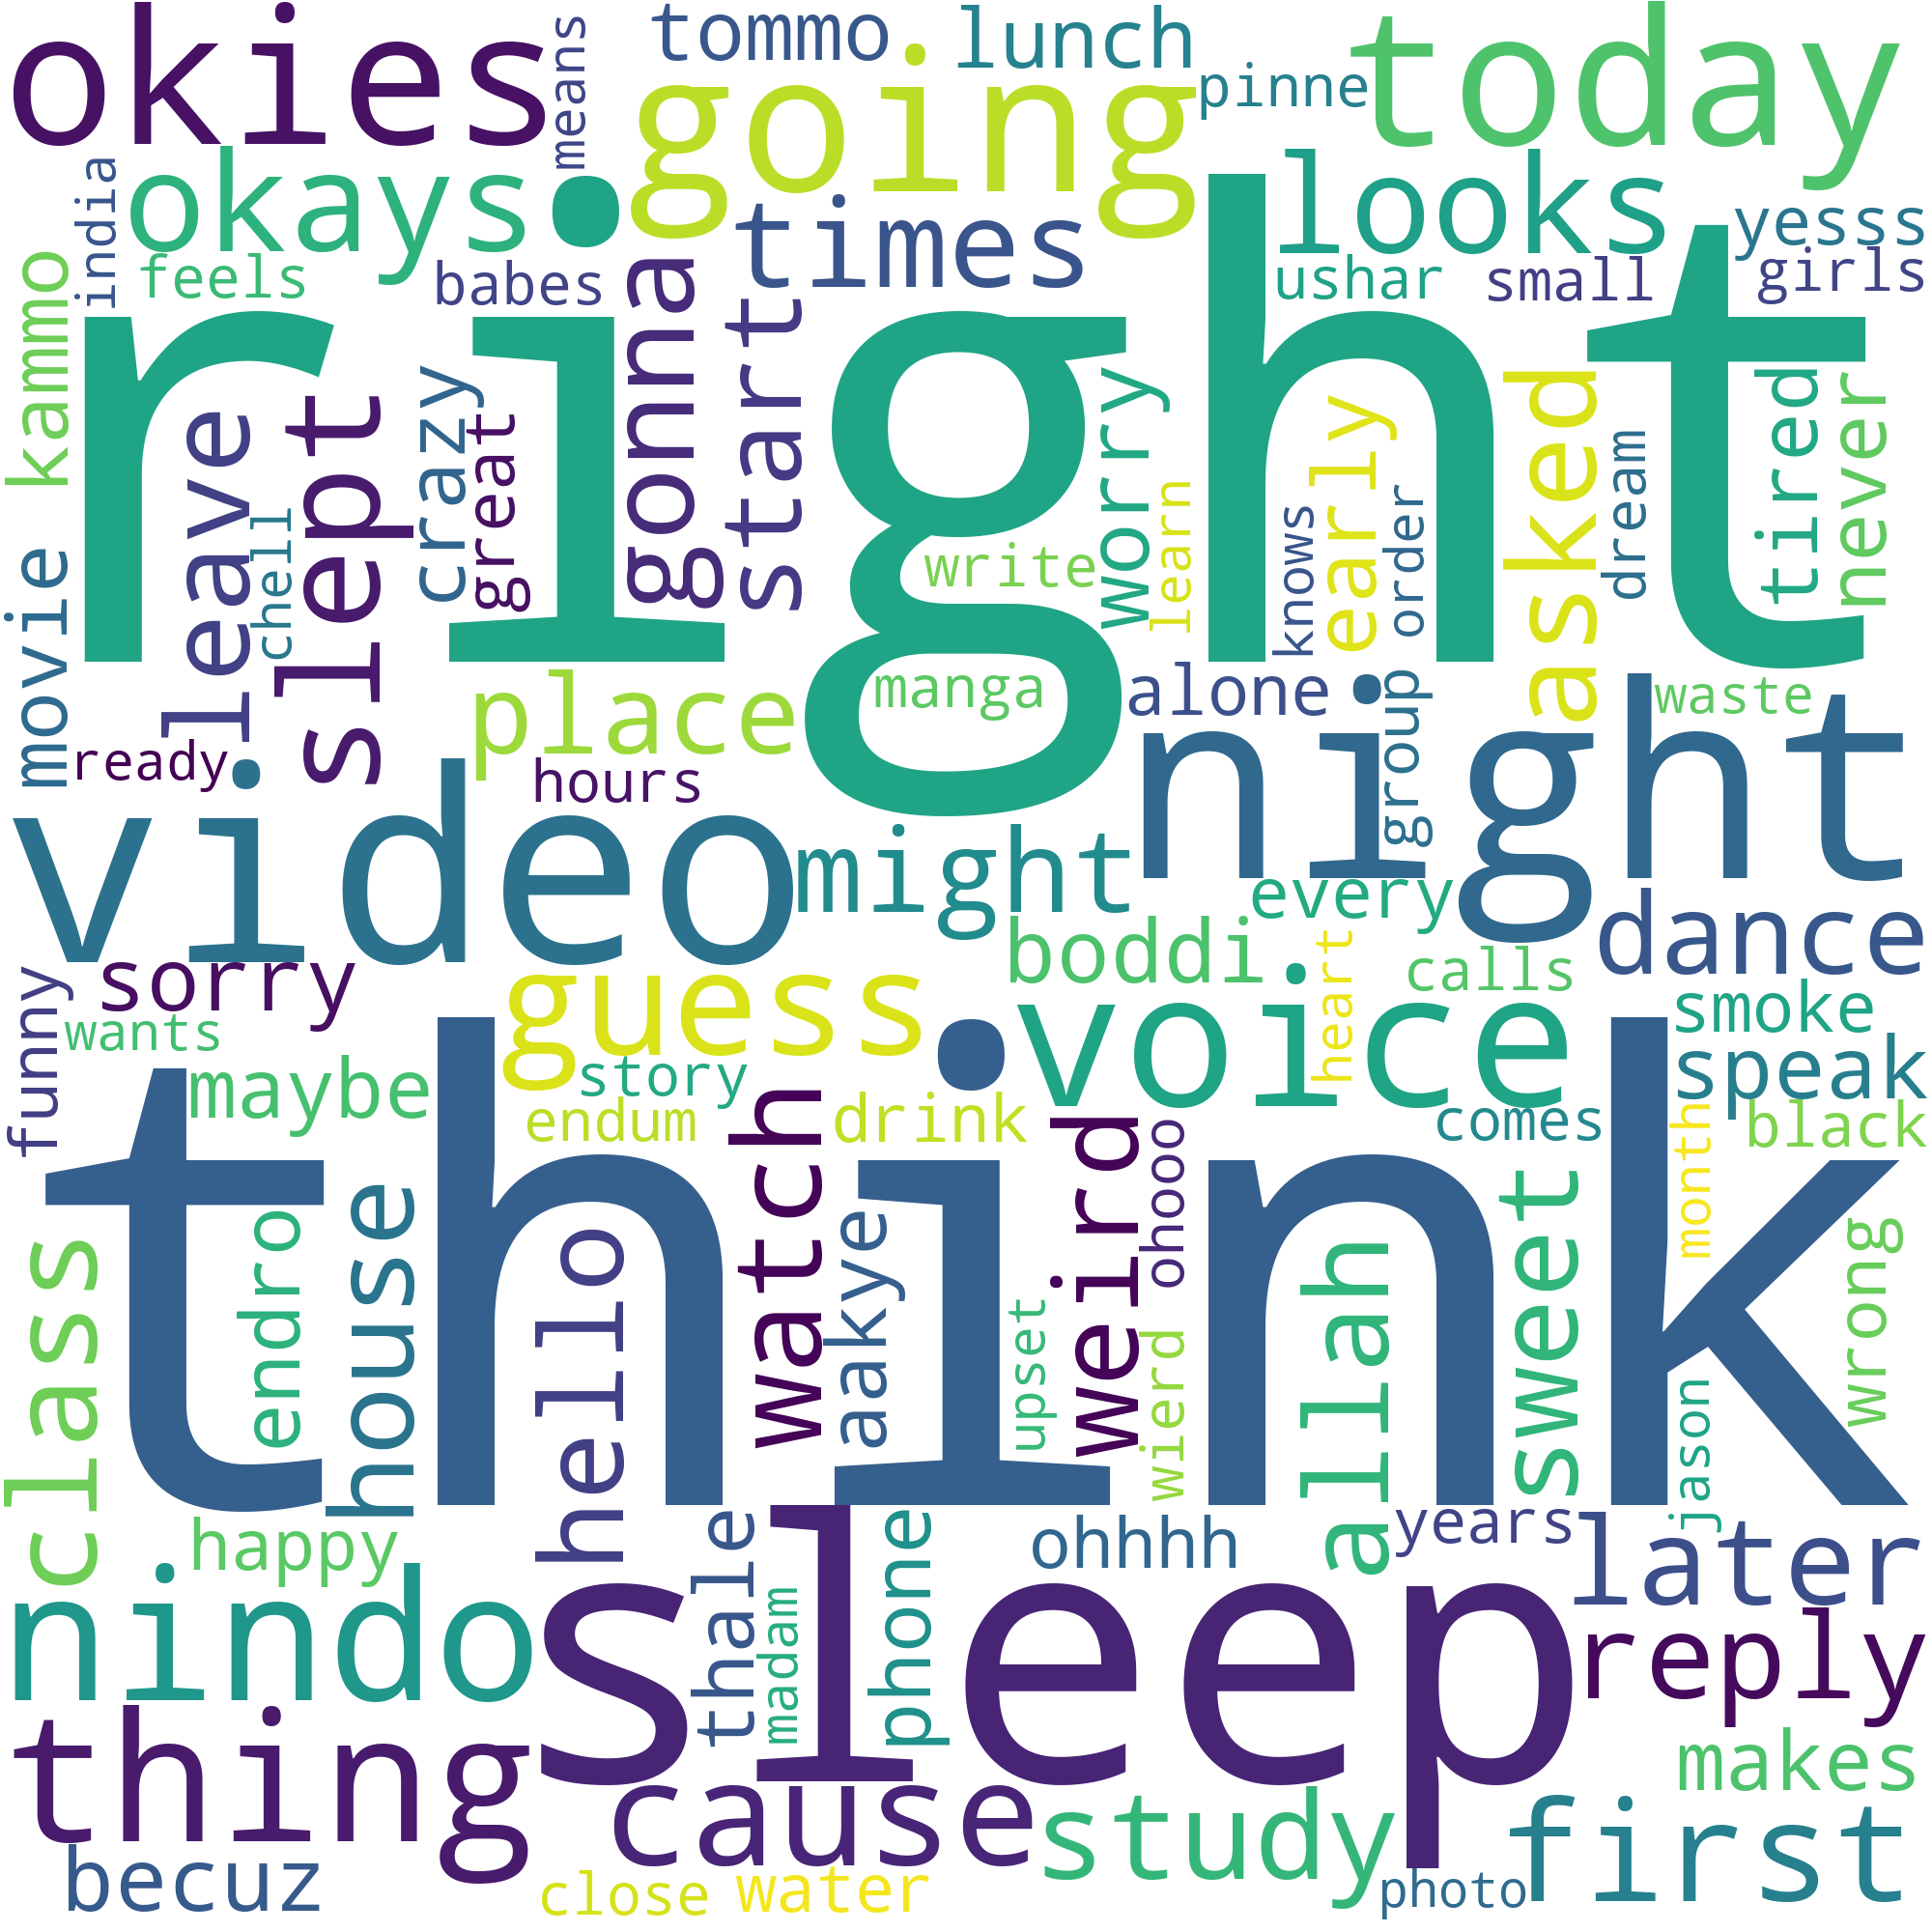

In [29]:
string = ' '.join(overall_selected_length_word_df.index)
wc=WordCloud(background_color="white", height=2000, width=2000, max_words=100).generate(string)

fig = go.Figure()


# figure for word cloud
wc_img = wc.to_image()
with BytesIO() as buffer:
    wc_img.save(buffer, 'png')
    img2 = base64.b64encode(buffer.getvalue()).decode()

img_width = 1000
img_height = 800
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
fig.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
fig.update_xaxes(visible=False, range=[0, img_width * scale_factor])

fig.update_yaxes(visible=False, range=[0, img_height * scale_factor],scaleanchor="x") # the scaleanchor attribute ensures that the aspect ratio stays constant
# Add image
fig.add_layout_image(
    dict(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=wc_img
    )
)


fig.update_layout ( 
    height=650 , width=650, 
    hoverlabel = hover_label_style,
    title_text='word cloud',
    yaxis = axis_style,
    margin= margin_style,
    plot_bgcolor='white',
    showlegend=False
    
)

#pyo.plot(fig, filename = 'group_activity.html')
#ls_figures.append(fig)

#### Code to convert ravindra iphone group chat to android analyis

'''
remember to remove all the sticker, image etc ommited to media omitted

pat = "^((\[)([0-2][0-9]|[3][0-1])\/([0][1-9]|[1][0-2])(\/)([0-2][0-9]), (([0-9]:[0-5][0-9]:[0-5][0-9]) (AM|PM)|([1][0-2]:[0-5][0-9]:[0-5][0-9]) (AM|PM))(\]))"
wr = open("Manali Group.txt", "w",  encoding="utf-8")
with open("IphoneManaliGroup.txt" , encoding="utf-8") as read:
    while True:
        x = read.readline()
        if not x:
            break
        
        if (re.match(pat,x)) or x.endswith('omitted\n'):
            ls = x.replace('\u200e','').strip().split(']',1)
            #print(ls)
            wr.write(ls[0][1:-6]+ls[0][-3:].lower()+' -'+ls[1]+"\n")
        else:
            wr.write(x.replace('\u200e','').strip()+'\n')
wr.close()
'''